<a href="https://colab.research.google.com/github/jindaldisha/type_of_food_classification/blob/main/food_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Food Classification

We're going to use the tensorflow dataset `food101`. This dataset consists of 101 food categories, with 101,000 images. The training dataset has 75,750 images and the test dataset has 25,250 images.

In [ ]:
#Import Libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import datetime

##Import Data

We're going to download the `food101` dataset from `TensorFLow Datasets (TFDS)` in tensor format. Since there is only training and testing set originally, we're going to split the training data into training and validation sets. We'll also shuffle the files to increase generalization while training. The dataset will be downloaded in the tuple format of (image, label).

In [ ]:
(train_data, test_data), ds_info = tfds.load(name='food101', #target dataset to get from tfds
                                             split=['train', 'validation'], #split it into training and validation sets
                                             shuffle_files = True, #shuffle the files on download
                                             as_supervised = True, #download data in tuple format of (image, label)
                                             with_info = True #include dataset metadata
                                             )

In [ ]:
#Features of dataset
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
#Get classes 
classes = ds_info.features['label'].names
print("Number of classes: ", len(classes))
print("Classes: ", classes)

Number of classes:  101
Classes:  ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_

In [ ]:
#Take a training sample and view its details
training_sample = train_data.take(1) #in the form of (image tensor, label)

In [ ]:
for image, label in training_sample:
  print("Image Shape: ", image.shape)
  print("Image dtype: ", image.dtype)
  print("Target Class: ", label)
  print("Class Name: ", classes[label])

Image Shape:  (512, 289, 3)
Image dtype:  <dtype: 'uint8'>
Target Class:  tf.Tensor(45, shape=(), dtype=int64)
Class Name:  frozen_yogurt


In [ ]:
#View image tensor
image

<tf.Tensor: shape=(512, 289, 3), dtype=uint8, numpy=
array([[[145, 151, 125],
        [157, 163, 137],
        [159, 165, 139],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [197, 207, 198]],

       [[146, 152, 126],
        [156, 162, 136],
        [158, 164, 138],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 200]],

       [[150, 156, 130],
        [155, 161, 135],
        [157, 163, 137],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 198]],

       ...,

       [[173, 186, 177],
        [174, 187, 178],
        [176, 189, 180],
        ...,
        [181, 197, 187],
        [181, 197, 187],
        [178, 195, 187]],

       [[176, 187, 179],
        [176, 187, 179],
        [176, 189, 180],
        ...,
        [182, 198, 188],
        [182, 198, 188],
        [180, 197, 189]],

       [[178, 189, 181],
        [177, 188, 180],
        [175, 188, 179],
        ...,
        [179, 195, 18

In [ ]:
#Range of a pixel value
print('Max Pixel Value: ', tf.reduce_max(image).numpy())
print('Min Pixel Value: ', tf.reduce_min(image).numpy())

Max Pixel Value:  255
Min Pixel Value:  0


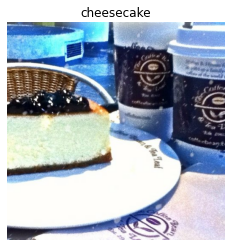

In [ ]:
#Plot an image tensor
plt.imshow(image)
plt.title(classes[label])
plt.axis(False);

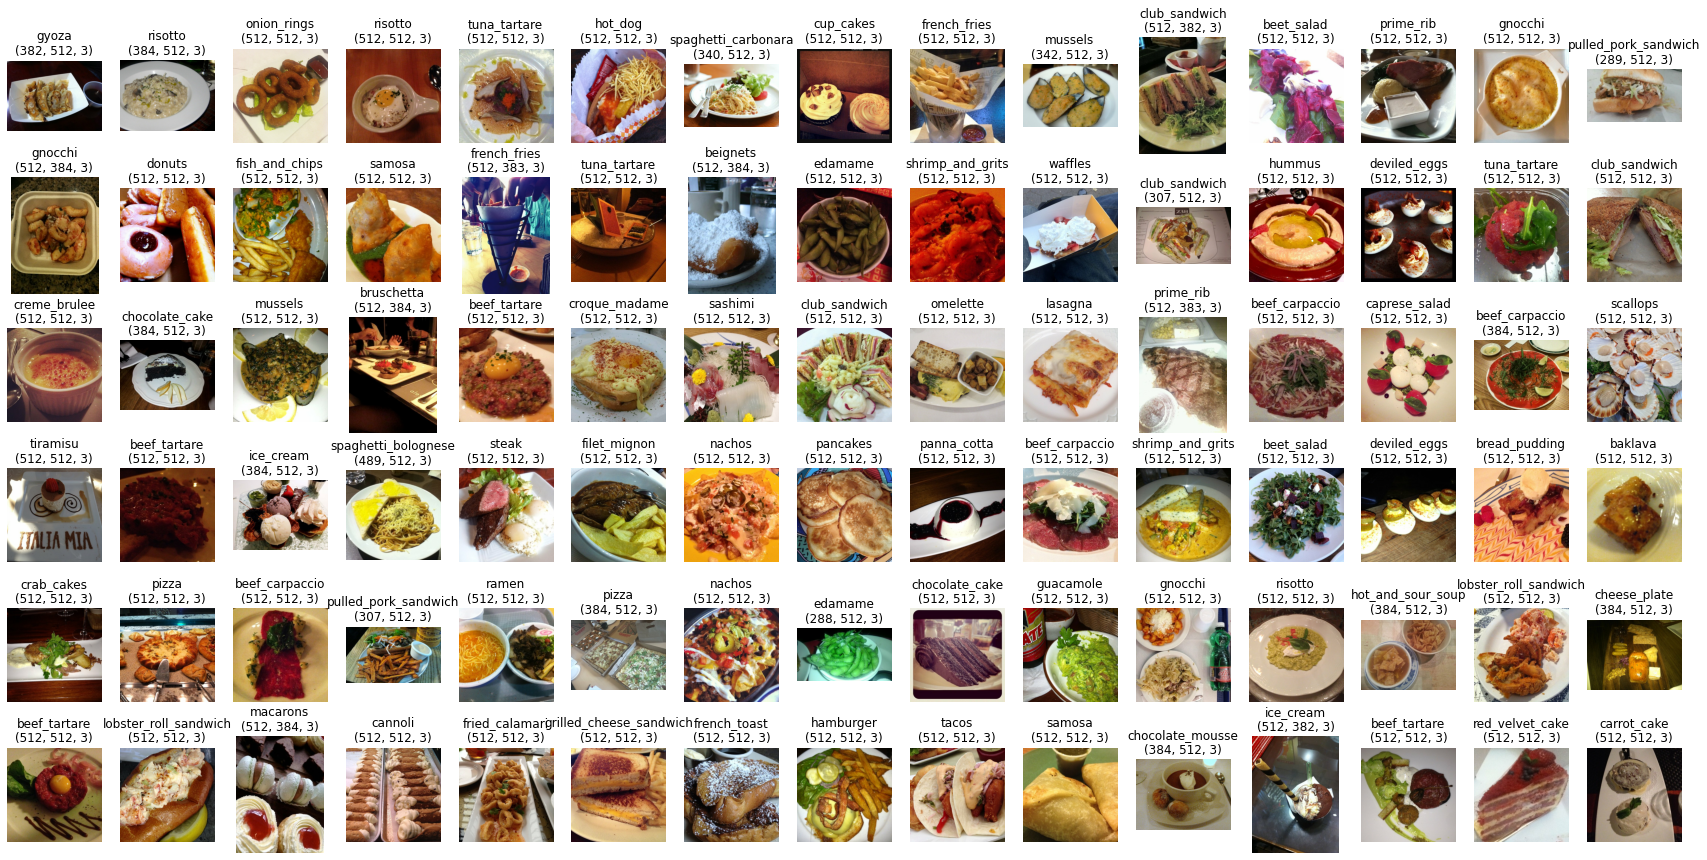

In [ ]:
#Plot multiple random images 
plt.figure(figsize=(30,15))
sample_images = train_data.take(90)
i = 1
for image, label in sample_images:
  ax = plt.subplot(6,15,i)
  i += 1
  plt.imshow(image)
  plt.title(f'{classes[label]}\n{image.shape}')
  plt.axis(False);

##Preprocessing Data

Since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before our data is ready to model.
Our data is currently:
- In `unint8` data type
- Comprises of tensors of different shape (different sized images)
- Not scaled (Since we're working on an images dataset, the max value of our data is 255 and the min value is 0.)

What we want our data to be:
- In `float32` data type
- All image tensors of same shape (since we're going to turn our data into batches, it requires that all tensors be of same shape).
- Scaled (Neural Networks prefer data to be scaled. To get better results, we need to normalize our data i.e turn it into range of (0,1).  We can normalize our data by dividing it by the max value i.e. dividing it by 255.)

We'll create a `preprocess_image()` function which will take image and labels as input and:
- Resize an input image tensor to a specific size
- Convert an input image tensor' datatypr to `tf.float32`. 
- Since we're going to be using the pretrained EfficientNetBX model, it already has rescaling built-in. Therefore we don't need to rescale it in our function.

In [ ]:
def preprocess_image(image, label, image_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [image_shape, image_shape, color_channels]
  """

  image  = tf.image.resize(image, [image_shape, image_shape]) #reshape
  image = tf.cast(image, tf.float32) #typecast
  return image, label

In [ ]:
#Test the preprocessing function on a sample image
preprocessed_image = preprocess_image(image, label)[0]
print("Before Preprocessing: ",
      "\nImage Shape: ", image.shape,
      "\nImage dtype: ", image.dtype)

print("After Preprocessing: ",
      "\nImage Shape: ", preprocessed_image.shape,
      "\nImage dtype: ", preprocessed_image.dtype)


Before Preprocessing:  
Image Shape:  (384, 512, 3) 
Image dtype:  <dtype: 'uint8'>
After Preprocessing:  
Image Shape:  (224, 224, 3) 
Image dtype:  <dtype: 'float32'>


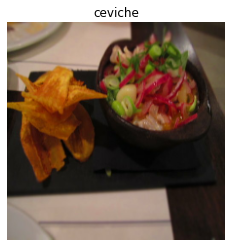

In [ ]:
#Plot the preprocessed image tensor
plt.imshow(preprocessed_image/255.)
plt.title(classes[label])
plt.axis(False);

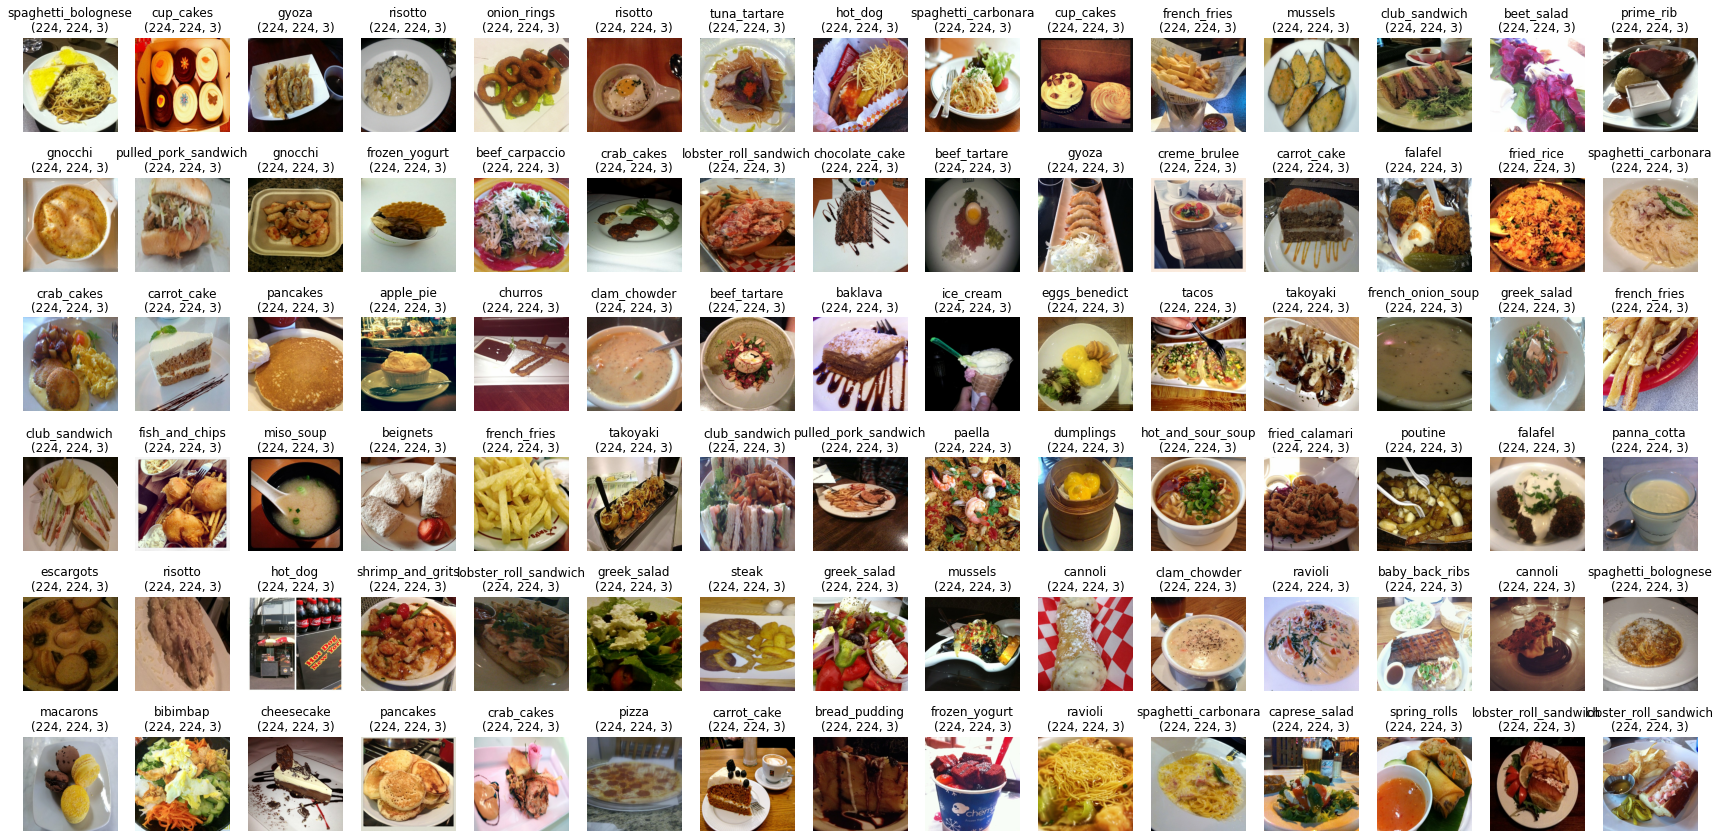

In [ ]:
#View images from train dataset after preprocessing
plt.figure(figsize=(30,15))
sample_images = train_data.take(90)
i = 1
for image, label in sample_images:
  image = preprocess_image(image, label)[0]
  ax = plt.subplot(6,15,i)
  i += 1
  plt.imshow(image/255.)
  plt.title(f'{classes[label]}\n{image.shape}')
  plt.axis(False);

##Batch and Prepare Datasets

When working with large datasets, its not possible to train the entire dataset at once as it may not fit into the memory and even if it does, the entire process will be very slow. And therefore what we do instead is take the dataset and break it into batches and train our model batch by batch. We're also going to shuffle our dataset to generalize our model.

We will turn our data from 101,000 image tensors and labels into batches of 32 image and label pairs. We're going to use methods from `tf.dataAPI`.
- `map()`: map a predefined function to a target dataset 
- `shuffle()`: randomly shuffle elements of the target dataset
- `batch()`: turn elements of a target dataset into batches of `batch_size`
- `cache()`: caches elements in a target dataset and saves loading rime.

In other words, we're going to map our preprocessing function across our training dataset then shuffle the elements before batching them together and making sure to prepare new batches (prefetch) whilst the model is looking at the current batch. This makes the process faster.

In [ ]:
#Map preprocessing function to the training data and parallelize
train_data = train_data.map(
    map_func = preprocess_image,
    num_parallel_calls = tf.data.AUTOTUNE #autotune the number of processors used (utilize as many processor as you can find)
    )

#Shuffle train_data and turn it into batches and prefetch
train_data = train_data.shuffle(
    buffer_size = 1000 #how many elements to shuffle at a single time
    ).batch(
        batch_size = 32 #number of elements in a batch
        ).prefetch(
            buffer_size = tf.data.AUTOTUNE
        )

#Map preprocessing function to the test data and parallelize
test_data = test_data.map(map_func = preprocess_image,
                          num_parallel_calls = tf.data.AUTOTUNE)

#Turn test data into batches (no need to shuffle)
test_data = test_data.batch(
    batch_size = 32).prefetch(
        buffer_size = tf.data.AUTOTUNE
    )

In [ ]:
#View prepared datasets
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

Our data is now of the form `(image_tensor, label)` with dtype `(tf.float32, tf.int64)`. Also our images tensors are now of the shape `(224, 224, 3)`.

##Modelling Callbacks

Since we're going to be training our model on a large amount of data and training takes a long time, we're going to set up some modelling callbacks so that we can track our model's training logs and make sure our model is being checkpointed after various training milestones.

We'll use `tf.keras.callbacks.TensorBoard()` as it allows us to keep track of our model's training history so we can inspect it later. `tf.keras.callbacks.ModelCheckpoint()` saves our model's progress at various intervals so that we can load it and reuse it later without having to retain it. This is also helpful when we fine-tune our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits.



In [ ]:
#Function to create tensorboard callback
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instance to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory
  """
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensor_board_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f'Saving TensorBoard log file to: {log_dir}')
  return tensor_board_callback

In [ ]:
#Create ModelCheckpoint callback to save model's progress during training
#We're only going to save the model's weights as it is a lot faster than storing the whole model
checkpoint_path = 'model_checkpoint/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor = 'val_accuracy', #save model weights with validation accuracy
    save_best_only = True, #only save best weights
    save_weights_only = True, #only save model weights
    verbose = 0)

##Feature Extraction Model

Since our dataset is quite large, we're going to fine-tune an existing pretrained model. But first we need to set up a feature-extraction model.
When transfer-learning, the typical order is:
- Build a feature extraction model ( replace the top few layers of a pretrained model).
- Train for a few epochs with lower (base) layers frozen.
- Fine-tune if necessary with multiple layers unfrozen.

To build the featurw extraction model:
- We're going to use `EfficientNetB0` from `tf.keras.applications` pre-trained on ImageNet as our base model. 
- First we will download without top layers using `include_top=False` parameter so that we can create our own output layers.
- We'll freeze the base model layer so that we can use the pre-trained patterns the base model has found on ImageNet.
- We will then put together the input, base model, pooling layers and output layer in a functional model.
- Then compile the functional model using Adam optimizer and sparse categorical crossentropy as the loss function since our labels aren't one-hot encoded.
- Then fit the model using TensorBoarf and ModelCheckpoint callbacks.

In [ ]:
#Download base model and freeze underlying layers

input_shape = (224, 224, 3)
#Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
#Freeze base model layers
base_model.trainable = False 

#Create functional model
inputs  = tf.keras.layers.Input(shape=input_shape, name='input_layer')
#Set base model to inference model only
x = base_model(inputs, training=False) 
x = tf.keras.layers.GlobalAveragePooling2D(name='pooling_layer')(x)
outputs = tf.keras.layers.Dense(len(classes), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

#Compile the model
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
#Check model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


we'll fit the feature extraction model for 3 epochs. That should be enough for our top layer to adjust their weights enough to our data. To save time per epoch, we'll validate only 15% of the test data.

In [ ]:
#Fit the Model
history = model.fit(
    train_data,
    epochs = 3,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    callbacks = [create_tensorboard_callback('training_logs', 'efficientnetb0_101_feature_extract'),
                 model_checkpoint]
)

Saving TensorBoard log file to: training_logs/efficientnetb0_101_feature_extract/20210813-041725
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 244s 88ms/step - loss: 1.8220 - accuracy: 0.5567 - val_loss: 1.2340 - val_accuracy: 0.6782
Epoch 2/3
2368/2368 [==============================] - 180s 75ms/step - loss: 1.2951 - accuracy: 0.6660 - val_loss: 1.1297 - val_accuracy: 0.6986
Epoch 3/3
2368/2368 [==============================] - 182s 76ms/step - loss: 1.1450 - accuracy: 0.7021 - val_loss: 1.0801 - val_accuracy: 0.7076


In [ ]:
#Function to plot loss curves
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))
  plt.figure(figsize=(20,7))
  #Plot Loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss', marker='x', c='forestgreen', ls='-')
  plt.plot(epochs, val_loss, label='val_loss', marker='x', c='deepskyblue', ls='-')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #Plot Accuracy
  plt.subplot(1,2,2)
  plt.ylim(0,1)
  plt.plot(epochs, accuracy, label='training_accuracy', marker='x', c='forestgreen', ls='-')
  plt.plot(epochs, val_accuracy, label='val_accuracy', marker='x', c='deepskyblue', ls='-')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

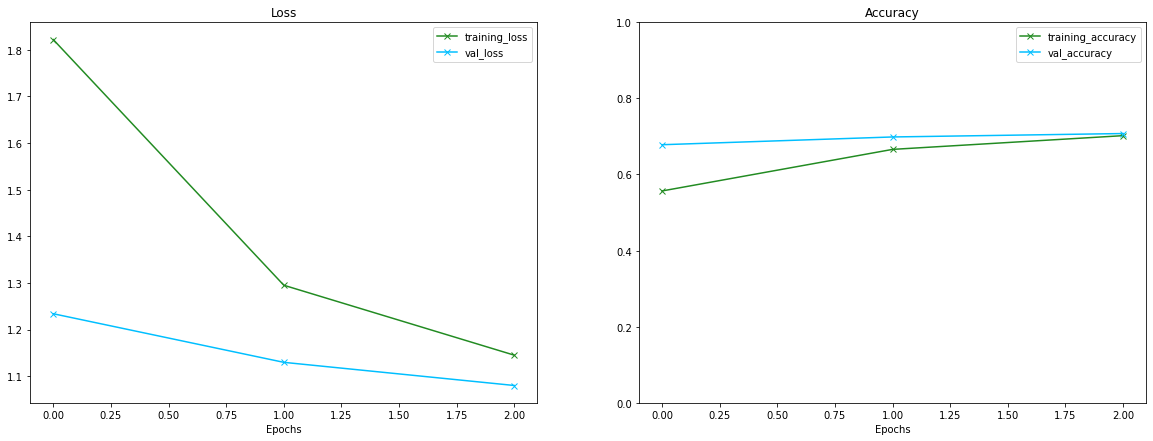

In [ ]:
plot_loss_curves(history)

In [ ]:
#Evaluate model on whole test dataset
result_feature_extraction = model.evaluate(test_data)
result_feature_extraction

790/790 [==============================] - 61s 77ms/step - loss: 1.0856 - accuracy: 0.7078


[1.0856236219406128, 0.7078019976615906]

##Load and Evaluate Checkpoint Weights

Since we used `ModelCheckpoint` callback, we've got a saved version of our model in the `model_checkpoints` directory.
We can load in and evaluate our model's checkpoints by:
- Cloning our model using `tf.keras.models.clone_model()` to make a copy of our feature extraction model with reset weights.
- Calling the `load_weight()` method on our cloned model passing it the path to where our checkpointed weights are stored.
- Calling `evaluate()` on the cloned model with loaded weights.

In [ ]:
#Clone the model (reset all weights)
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
#Checkpoint path
checkpoint_path

'model_checkpoint/cp.ckpt'

In [ ]:
#Load checkpointed weights into the cloned model
cloned_model.load_weights(checkpoint_path)

In [ ]:
#Compile the cloned model (with same parameters as original model)
#Since each time we make a change to the model we need to recompile it
cloned_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [ ]:
#Evaluate cloned model with loaded weights 
result_cloned_model = cloned_model.evaluate(test_data)

790/790 [==============================] - 55s 67ms/step - loss: 1.0856 - accuracy: 0.7078


Since we're using the weights of our feature extraction model in our cloned model, the result should be very close if not exactly the same to that of the feature extraction model.

In [ ]:
#Check if the weights are exact same
result_feature_extraction == result_cloned_model

False

The above cell outputs `False` because the numbers are close but not the exact same. It all comes down to the precision level of numbers calculated.

In [ ]:
#Check if the weight are close
np.isclose(result_feature_extraction, result_cloned_model).all()

True

In [ ]:
#Check the difference between the two results
print(np.array(result_feature_extraction) - np.array(result_cloned_model))

[-9.53674316e-07  0.00000000e+00]


##Save the Model

Since our model is quite large, we'll save it in google drive.

In [ ]:
#Saving model to google drive
drive_path = 'drive/MyDrive/Tensorflow/food101/feature_extraction_model/'
#Make path if it doesnot exist
os.makedirs(drive_path)
#Save model
model.save(drive_path)

In [ ]:
#Check whether the model has been saved
loaded_model = tf.keras.models.load_model(drive_path)

In [ ]:
#Evaluate loaded model
result_loaded_model = loaded_model.evaluate(test_data)

790/790 [==============================] - 54s 69ms/step - loss: 1.0856 - accuracy: 0.7078


In [ ]:
#Check if the weight are close
np.isclose(result_feature_extraction, result_loaded_model).all()

True

Our model has been saved successfully. It is important to make sure that a model has been saved correctly becuase training on a lot of data is time consuming and we dont want to train the model everytime from scratch.

##Fine-tuning the model

We get an accuracy of around `71%` after training our feature extraction model on three epochs. We can increase the performance of our model by fine-tuning it. When fine-tuning, the traditional workflow is to freeze the pre-trained base model and then train only the output layers for a few iterations so that the weights can be updated inline with the custom data. And then unfreeze a number or all of the layers in the base model and continue training until the model stops imporving.

In [ ]:
#View summary of the loaded model
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


When we first created the feature extraction model, we froze all of the layers in the base model by setting `base_model.trainable = False`. But since we loaded in our model from file, we can set `base_model.trainable = True`.

In [ ]:
#Set all the layers to trainable
for layer in loaded_model.layers:
  layer.trainable = True 
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
pooling_layer True
dense True


In [ ]:
#Check all the layers in the base model
for layer in loaded_model.layers[1].layers[:]:
  print(layer.name, layer.trainable)

Since we've got (750 images x 101 training classes = 75750 training images), let's keep all of our base model's layers unfrozen.

##Callbacks for Fine-Tuning

We will also use `tf.keras.callbacks.EarlyStopping()` as it monitors a specific model performance metric and when it stops improving for a specific number of epochs, it automatically stops the training of our model.

Since we're using `EarlyStopping` callback combined with the `ModelCheckpoint` callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

In [ ]:
#Setup EarlyStopping callback to stop training if the model's val_loss doesnt improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', #monitor validation loss metric
    patience = 3 #if val loss doesnt decrese for 3 epoch in a row, stop training
)

#Create ModelCheckpoint call to save best model during fine-tuning
checkpoint_path = 'fine_tune_checkpoints/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor = 'val_loss',
    save_best_only = True)

We will also use the `ReduceLROnPlateau` callback. As the name suggests, it helps in tuning the learning rate. It monitors a specific metric and when the metric stops improving, it reduces the learning rate by a specific factor. When our model gets closer to its ideal performance, i.e when it starts to converge, we want the size of steps to get smaller and smaller. We will monitor the validation loss, and when it stops improving for two or more epochs, we will reduce the learning rate by a fact of 5.
We will also set the minimum learning rate so as to make sure it doenst get too low.

In [ ]:
#Create learning rate reduction callback
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', #monitor the validation loss
    factor = 0.2, #multiply the learning rate by 0.2
    verbose = 1, #print when the learning rate changes
    min_lr = 1e-7 #mimimum learning rate
)

In [ ]:
#Compile the model
loaded_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(0.0001),
    metrics = ['accuracy']
)

Now we will fit the model for 100 epochs. Since we're using `EarlyStopping` callback. Since we've set all the layers in the base model to be trainable,fitting the model will fine-tune all of the pre-trained weights in the base model on the whoel food101 dataset. 

In [ ]:
#Start fine-tuning
history_fine_tune = loaded_model.fit(
    train_data,
    epochs = 100, #fine tune for max 100 epochs
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)), #validate on only 15% of the data
    callbacks = [create_tensorboard_callback('training_logs', 'model_fine_tuning'), #track training logs 
                 model_checkpoint, #save only the best model during training
                 early_stopping, #stop model after 3 epochs of no improvements
                 reduce_learning_rate #reduce learning rate after 3 epochs of no improvement
    ]
)

Saving TensorBoard log file to: training_logs/model_fine_tuning/20210813-061613
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 814s 336ms/step - loss: 0.9217 - accuracy: 0.7517 - val_loss: 0.8431 - val_accuracy: 0.7707


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 2/100
2368/2368 [==============================] - 796s 332ms/step - loss: 0.5777 - accuracy: 0.8408 - val_loss: 0.7721 - val_accuracy: 0.7937


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 3/100
2368/2368 [==============================] - 791s 333ms/step - loss: 0.3277 - accuracy: 0.9076 - val_loss: 0.8445 - val_accuracy: 0.7879
Epoch 4/100
2368/2368 [==============================] - 789s 333ms/step - loss: 0.1740 - accuracy: 0.9487 - val_loss: 1.0011 - val_accuracy: 0.7704
Epoch 5/100
2368/2368 [==============================] - 789s 333ms/step - loss: 0.1076 - accuracy: 0.9663 - val_loss: 1.0476 - val_accuracy: 0.7823


In [ ]:
#Saving model to google drive
drive_path = 'drive/MyDrive/Tensorflow/food101/fine_tuned_model2/'
#Make path if it doesnot exist
os.makedirs(drive_path)
#Save model
loaded_model.save(drive_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/Tensorflow/food101/fine_tuned_model2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Tensorflow/food101/fine_tuned_model2/assets


In [ ]:
#Evaluate the model
result_fine_tuned_model = loaded_model.evaluate(test_data)

790/790 [==============================] - 60s 76ms/step - loss: 1.0404 - accuracy: 0.7807


We got an accuracy of `~78%` top-1 accuracy. 

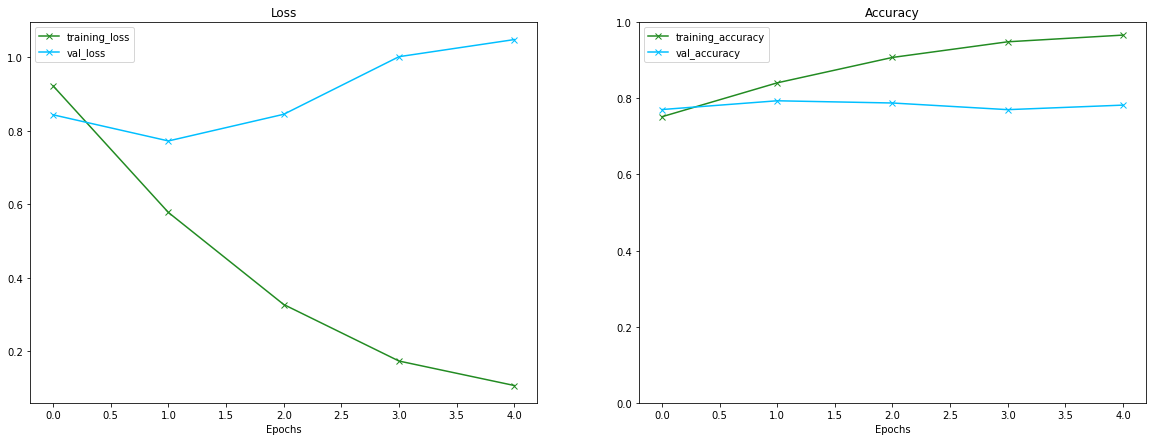

In [ ]:
#Plot loss curves
plot_loss_curves(history_fine_tune)

Training accuracy seems to be steadily increasing, but validation accuracy seems to have peaks and valleys, but overall it does increase. This might be a sign of some overfitting, but definitely not a large amount of overfitting.